In [1]:
import pyarrow as pa
from pyarrow import csv
import pandas as pd
import pyarrow.feather as feather
from rdkit.Chem import PandasTools

from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit import DataStructs
from rdkit import Chem
from rdkit.Chem import rdMolDescriptors
import numpy as np
import numpy.ma as ma
import tqdm
import pyarrow.parquet as pq
import numpy as np
from scipy import sparse
import pandas as pd
import math
import time
from functools import reduce
import pyarrow.dataset as ds
from pyarrow import Table
from pyarrow import csv
import pyarrow as pa
from pyarrow.parquet import ParquetWriter
import pathlib
import ray
import pyarrow.feather as fe
import datamol as dm
import operator

from datetime import timedelta
from timeit import time
dm.disable_rdkit_log()
#autocomplete wasn't working for some reason. This fixes it. 
%config Completer.use_jedi = False

In [2]:

def stopwatch(method):
    def timed(*args, **kw):
        ts = time.perf_counter()
        result = method(*args, **kw)
        te = time.perf_counter()
        duration = timedelta(seconds=te - ts)
        print(f"{method.__name__}: {duration}")
        return result
    return timed

def _preprocess(i, row):
#     print('hello')
    mol = dm.to_mol(str(row[smiles_column]), ordered=True)
    mol = dm.fix_mol(mol)
    mol = dm.sanitize_mol(mol, sanifix=True, charge_neutral=False)
    

    mol = dm.standardize_mol(mol, disconnect_metals=False, normalize=True, reionize=True, uncharge=False, stereo=True)

    fingerprint_function = rdMolDescriptors.GetMorganFingerprintAsBitVect
    pars = { "radius": 2,
                     "nBits": 8192,
                     "invariants": [],
                     "fromAtoms": [],
                     "useChirality": False,
                     "useBondTypes": True,
                     "useFeatures": False,
            }
    fp = fingerprint_function(mol, **pars)

    row["standard_smiles"] = dm.standardize_smiles(dm.to_smiles(mol))
    row["selfies"] = dm.to_selfies(mol)
    row["inchi"] = dm.to_inchi(mol)
    row["inchikey"] = dm.to_inchikey(mol)
    row["onbits_fp"] =list(fp.GetOnBits())
    
    return row



@stopwatch
def fingerprint_matrix_from_df(df):
    smiles = list(df['standard_smiles'])
    onbits_fp = list(df['onbits_fp'])
    zincid = list(df['canonical_id'])
    # pars = { "radius": 2,
    #          "nBits": 8192,
    #          "invariants": [],
    #          "fromAtoms": [],
    #          "useChirality": False,
    #          "useBondTypes": True,
    #          "useFeatures": False,
    #          }

    # fingerprint_function = rdMolDescriptors.GetMorganFingerprintAsBitVect        
    print(f'the number of smiles in the record batch is {len(smiles)}')
    count_ligs = len(smiles)



    # scores_list = []
    name_list =[]
    # smiles_list = []
    row_idx = list()
    col_idx = list()
    num_on_bits = []
    for count,m in enumerate(smiles):
    #     m_in = str(m)
    #     mol = Chem.MolFromSmiles(m_in)
    #     fp = fingerprint_function(mol, **pars)
    #     score = str(scores[count])
        zincid_name = str(zincid[count])
        onbits = list(onbits_fp[count])
    #     print(onbits)

    #     print(type(onbits))
        col_idx+=onbits
        row_idx += [count]*len(onbits)
        num_bits = len(onbits)
        num_on_bits.append(num_bits)
    #     scores_list.append(score)
        name_list.append(zincid_name)


        # except:
        #     print('molecule failed')

    unfolded_size = 8192        
    fingerprint_matrix = sparse.coo_matrix((np.ones(len(row_idx)).astype(bool), (row_idx, col_idx)), 
              shape=(max(row_idx)+1, unfolded_size))
    fingerprint_matrix =  sparse.csr_matrix(fingerprint_matrix)
    fp_mat = fingerprint_matrix
    print('Fingerprint matrix shape:', fp_mat.shape)
    print('\n')
    print('Indices:', fp_mat.indices)
    print('Indices shape:', fp_mat.indices.shape)
    print('\n')
    print('Index pointer:', fp_mat.indptr)
    print('Index pointer shape:', fp_mat.indptr.shape)
    print('\n')
    print('Actual data (these are all just "ON" bits!):', fp_mat.data)
    print('Actual data shape:', fp_mat.data.shape)
    return fp_mat

@stopwatch
def fast_dice(X, Y=None):
    if isinstance(X, np.ndarray):
        X = sparse.csr_matrix(X).astype(bool).astype(int)
    if Y is None:
        Y = X
    else:
        if isinstance(Y, np.ndarray):
            Y = sparse.csr_matrix(Y).astype(bool).astype(int)
            
    intersect = X.dot(Y.T)
    #cardinality = X.sum(1).A
    cardinality_X = X.getnnz(1)[:,None] #slightly faster on large matrices - 13s vs 16s for 12k x 12k
    cardinality_Y = Y.getnnz(1) #slightly faster on large matrices - 13s vs 16s for 12k x 12k
    return (1-(2*intersect) / (cardinality_X+cardinality_Y.T)).A

@stopwatch
def fast_jaccard(X, Y=None):
    """credit: https://stackoverflow.com/questions/32805916/compute-jaccard-distances-on-sparse-matrix"""
    if isinstance(X, np.ndarray):
        X = sparse.csr_matrix(X)
    if Y is None:
        Y = X
    else:
        if isinstance(Y, np.ndarray):
            Y = sparse.csr_matrix(Y)
    assert X.shape[1] == Y.shape[1]

    X = X.astype(bool).astype(int)
    Y = Y.astype(bool).astype(int)
    intersect = X.dot(Y.T)
    x_sum = X.sum(axis=1).A1
    y_sum = Y.sum(axis=1).A1
    xx, yy = np.meshgrid(x_sum, y_sum)
    union = ((xx + yy).T - intersect)
    return (1 - intersect / union).A

@stopwatch
def _show_nearest_neighbor(i, row):

    """Use the output matrix from similarity search to find nearest neighbors from the
    reference matrix. out_array must be a globally defined variable for this to work.

    """
    a = out_array[i]




    minval = np.min(ma.masked_where(a==0, a)) 


#     maxval = np.max(ma.masked_where(a==0, a)) 



    minvalpos = np.argmin(ma.masked_where(a==0, a))  



#     maxvalpos = np.argmax(ma.masked_where(a==0, a))  

    
    smiles_nn = smiles[minvalpos]
    name_nn = name[minvalpos]



    row["nearest_neighbor_smiles"] = smiles_nn 
    row["nearest_neighbor_name"] = name_nn
    row["nearest_neighbor_distance"] = minval
    return row

@stopwatch
def ingest_chembl_smi(smi_path, smiles_column, canonical_id_column, activity_column):
    
    """Convert an smi file with a smiles column to a molchunk. It is assumed that
        the SMI has been cleaned (no header, and other columns have been removed).
        
    Args:
        smi_path: path to the smi file.
        smiles_column: column where the SMILES are located: f0 = col 1 f1 = col 2 .. etc
        canonical_id_column: name/id for molecule: f0 = col 1 f1 = col 2 .. etc
        activity column: column where bioactivity is listed (ki, ec50, etc): f0 = col 1 f1 = col 2 .. etc

    """

    
    # Next we will the multithreaded read options that pyarrow allows for.

    opts = pa.csv.ReadOptions(use_threads=True, autogenerate_column_names=True)

    # Then we tell pyarrow that the columns in our csv file are seperated by ';'
    # If they were tab seperated we would use '\t' and if it was comma we would use 
    # ','
    parse_options= pa.csv.ParseOptions(delimiter=' ')

    # Now we read the CSV into a pyarrow table. This is a columular dataset. More
    # on this later. Note how we specified the options above.

    table = pa.csv.read_csv(smi_path, opts, parse_options)


    # Now we will use a function that converts the pyarrow table into a pandas 
    # dataframe. We could have done this without arrow, but again -- there are 
    # very powerful tools that arrow will grant us.

    df_new = table.to_pandas()
 
    smiles_column = 'f0'
    
    # run initial mapper on smiles column to generate basic information and fingerprint on bits
    df_clean_mapped = dm.parallelized(_preprocess, list(df_new.iterrows()), arg_type='args', progress=True)
    df_clean_mapped = pd.DataFrame(df_clean_mapped)
    
    #rename columns
    df_clean_mapped['smiles'] = df_clean_mapped[smiles_column]
    df_clean_mapped['canonical_id'] = df_clean_mapped[canonical_id_column]
    df_clean_mapped['ki'] = df_clean_mapped[activity_column]
    
    #delete old columns
    del df_clean_mapped['f2']
    del df_clean_mapped['f1']
    del df_clean_mapped['f0']
    
    #remove duplicated standard SMILES and reindex
    duplicateRowsDF2 = df_clean_mapped[df_clean_mapped.duplicated(['standard_smiles'])]
#     print("Duplicate Rows based on a single column are:", duplicateRowsDF2, sep='\n')
    df_clean_mapped = df_clean_mapped.drop_duplicates(subset='standard_smiles', keep="first", inplace=False)
    df = df_clean_mapped.reset_index(drop=True)
    
    return df

@stopwatch
def ingest_chembl_raw_csv(csv_path):
    
    """Convert a csv file from chembl into a molchunk that has been processed with datamol.
        
    Args:
        csv_path: path to the csv file.


    """

    
    # Next we will the multithreaded read options that pyarrow allows for.

    opts = pa.csv.ReadOptions(use_threads=True)

    # Then we tell pyarrow that the columns in our csv file are seperated by ';'
    # If they were tab seperated we would use '\t' and if it was comma we would use 
    # ','
    parse_options= pa.csv.ParseOptions(delimiter=';')

    # Now we read the CSV into a pyarrow table. This is a columular dataset. More
    # on this later. Note how we specified the options above.

    table = pa.csv.read_csv(csv_path, opts, parse_options)


    #clean up the column names and convert the activity column to ki
    
    

    df_new = table.to_pandas()
    df_new['ki'] = df_new[['Standard Value']].astype(str).agg(''.join, axis=1)
    df_clean = df_new[['Molecule ChEMBL ID', 'ki', 'Smiles']]
    df_clean = df_clean.rename({'Molecule ChEMBL ID':'canonical_id', 'ki':'ki', 'Smiles':'smiles'}, axis='columns')
    df_clean['length'] = df_clean.smiles.str.len()
    df_clean = df_clean[df_clean.length > 0]
    del df_clean['length']

 
#     smiles_column = 'smiles'
    
#     run initial mapper on smiles column to generate basic information and fingerprint on bits
    df_clean_mapped = dm.parallelized(_preprocess, list(df_clean.iterrows()), arg_type='args', progress=True)
    df_clean_mapped = pd.DataFrame(df_clean_mapped)
    
    
    #remove duplicated standard SMILES and reindex
    duplicateRowsDF2 = df_clean_mapped[df_clean_mapped.duplicated(['standard_smiles'])]
    print("Duplicate Rows based on a single column are:", duplicateRowsDF2, sep='\n')
    df_clean_mapped = df_clean_mapped.drop_duplicates(subset='standard_smiles', keep="first", inplace=False)
    df_clean_mapped = df_clean_mapped.reset_index(drop=True)
    
    return df_clean_mapped


def _preprocess_addpartition_col_ray(count, row):
## This is hardcoded for now and should be fixed
    index = int(row[8])
    assigned_batch = math.ceil(index/rows_per_batch)
    if math.ceil(index/rows_per_batch) == 0:
        assigned_batch = 1

#     print(f'column number {count} finished')
    row["partition_col"] = assigned_batch 
    return row

from rdkit import Chem
import warnings

def has_all_chiral_defined_rd(smiles):
    try:
        undefined_atoms = []
        unspec_chiral = False
        mol = Chem.MolFromSmiles(smiles)
        mol = Chem.AddHs(mol)
        chiral_centers = Chem.FindMolChiralCenters(mol, includeUnassigned=True)
        for center in chiral_centers:
            atom_id = center[0]
            if center[-1] == '?':
                unspec_chiral = True
                undefined_atoms.append((atom_id, mol.GetAtomWithIdx(atom_id).GetSmarts()))
        if unspec_chiral:
            print(undefined_atoms)
            return False
        else:
            return True
    except:
        return False

def has_stereo_defined(molecule):
    """

    Parameters
    ----------
    molecule

    Returns
    -------

    """

    unspec_chiral = False
    unspec_db = False
    problematic_atoms = list()
    problematic_bonds = list()
    chiral_centers = Chem.FindMolChiralCenters(molecule, includeUnassigned=True)
    for center in chiral_centers:
        atom_id = center[0]
        if center[-1] == '?':
            unspec_chiral = True
            problematic_atoms.append((atom_id, molecule.GetAtomWithIdx(atom_id).GetSmarts()))

    # Find potential stereo bonds that are unspecified
    Chem.FindPotentialStereoBonds(molecule)
    for bond in molecule.GetBonds():
        if bond.GetStereo() == Chem.BondStereo.STEREOANY:
            unspec_db = True
            problematic_bonds.append((bond.GetBeginAtom().GetSmarts(), bond.GetSmarts(),
                                                bond.GetEndAtom().GetSmarts()))
    if unspec_chiral or unspec_db:
        warnings.warn("Stereochemistry is unspecified. Problematic atoms {}, problematic bonds {}".format(
                problematic_atoms, problematic_bonds))
        return False
    else:
        return True

In [3]:
# Ingest a preprocessed smi file and generate a fingerprint matrix
smi_path = '/data/d3_chembl.smi'
smiles_column = 'f0'
canonical_id_column = 'f1'
activity_column = 'f2'
d3_df = ingest_chembl_smi(smi_path, smiles_column, canonical_id_column, activity_column)

fingerprint_matrix_chembld3 = fingerprint_matrix_from_df(d3_df)




  0%|          | 0/11713 [00:00<?, ?it/s]

ingest_chembl_smi: 0:00:25.882512
the number of smiles in the record batch is 8781
Fingerprint matrix shape: (8781, 8192)


Indices: [ 373  379  653 ... 8017 8020 8133]
Indices shape: (466055,)


Index pointer: [     0     52    104 ... 465929 465993 466055]
Index pointer shape: (8782,)


Actual data (these are all just "ON" bits!): [ True  True  True ...  True  True  True]
Actual data shape: (466055,)
fingerprint_matrix_from_df: 0:00:00.105571


In [4]:
# Ingest a raw csv file from chembl and generate a fingerprint matrix
smiles_column = 'smiles'
csv_path = '--d2_chembl.csv'
d2_df = ingest_chembl_raw_csv(csv_path)
# fingerprint_matrix_chembld2 = fingerprint_matrix_from_df(d2_df)


  0%|          | 0/9804 [00:00<?, ?it/s]

Duplicate Rows based on a single column are:
       canonical_id       ki  \
87    CHEMBL4471658   138.04   
103        CHEMBL42   223.87   
134   CHEMBL4092441    240.0   
147    CHEMBL301265    7.079   
187     CHEMBL65847    179.0   
...             ...      ...   
9812  CHEMBL4546210  10800.0   
9813     CHEMBL1112    740.0   
9814      CHEMBL589    330.0   
9815  CHEMBL4475978    180.0   
9816  CHEMBL4589982    500.0   

                                                 smiles  \
87    Cc1cc(C(N)=O)c(-c2cccc(OC(=O)NCCN3CCN(c4ccccc4...   
103               CN1CCN(C2=Nc3cc(Cl)ccc3Nc3ccccc32)CC1   
134   O=c1ccc2c(N3CCN(CCCCOc4ccn5nccc5c4)CC3)ccc(O)c...   
147                            CCCN[C@H]1CCc2nc(N)sc2C1   
187               CCCN(Cc1ccccc1)[C@@H]1CCc2c(F)cccc2C1   
...                                                 ...   
9812  CCc1cc(Cl)c(OC)c(N2CCN(CC(F)CCNC(=O)c3cc4ccccc...   
9813    O=C1CCc2ccc(OCCCCN3CCN(c4cccc(Cl)c4Cl)CC3)cc2N1   
9814                       CCCN(CCC)CCc

In [5]:


rows_per_batch = 1000

d2_df['index'] = d2_df.index
df_clean_mapped = dm.parallelized(_preprocess_addpartition_col_ray, list(d2_df.iterrows()), arg_type='args', progress=True)
df_clean_mapped = pd.DataFrame(df_clean_mapped)
del df_clean_mapped['index']
df_pc = df_clean_mapped.reset_index(drop=True)

table = pa.Table.from_pandas(df_pc)
pq.write_to_dataset(table, root_path='/data/d2_output', partition_cols=['partition_col'], 
                    flavor='spark')

  0%|          | 0/6572 [00:00<?, ?it/s]

In [6]:
#define smiles and names for compounds in the matrix to be compared with
#this will be the key system for returning the nearest neighbor
smiles = list(d3_df['standard_smiles'])
name = list(d3_df['canonical_id'])


# Load the dataset from parquet one by one
dataset = ds.dataset('/data/d2_output', format="parquet")

# Create a list of fragments that are not memory loaded
fragments = [file for file in dataset.get_fragments()]


for count, element in enumerate(fragments):
    #cast the fragment as a pandas df
    df_docked = element.to_table().to_pandas()
    #reset the index
    df_docked = df_docked.reset_index(drop=True)
    
    #make the fp matrix
    fingerprint_matrix_in = fingerprint_matrix_from_df(df_docked)
    
    #make the jaccard matrix
    out_array = fast_jaccard(fingerprint_matrix_in, fingerprint_matrix_chembld3)
    
    #now write the nearest neighbor name and smiles to the df
    smiles_column = 'standard_smiles'
    df_add_nn = dm.parallelized(_show_nearest_neighbor, list(df_docked.iterrows()), arg_type='args', progress=True)
    df_add_nn = pd.DataFrame(df_add_nn)
    
    #write the mochunk to disk
    feather.write_feather(df_add_nn, f'/data/outchunks/comparison_{count}.molchunk')



the number of smiles in the record batch is 1001
Fingerprint matrix shape: (1001, 8192)


Indices: [  41  347  611 ... 7652 7935 8017]
Indices shape: (52361,)


Index pointer: [    0    56   113 ... 52253 52308 52361]
Index pointer shape: (1002,)


Actual data (these are all just "ON" bits!): [ True  True  True ...  True  True  True]
Actual data shape: (52361,)
fingerprint_matrix_from_df: 0:00:00.038834
fast_jaccard: 0:00:01.175327


  0%|          | 0/1001 [00:00<?, ?it/s]

the number of smiles in the record batch is 1000
Fingerprint matrix shape: (1000, 8192)


Indices: [ 197  695  841 ... 7652 8017 8059]
Indices shape: (53265,)


Index pointer: [    0    63   104 ... 53162 53208 53265]
Index pointer shape: (1001,)


Actual data (these are all just "ON" bits!): [ True  True  True ...  True  True  True]
Actual data shape: (53265,)
fingerprint_matrix_from_df: 0:00:00.043567
fast_jaccard: 0:00:01.139794


  0%|          | 0/1000 [00:00<?, ?it/s]

the number of smiles in the record batch is 1000
Fingerprint matrix shape: (1000, 8192)


Indices: [ 146  656  950 ... 7935 8006 8017]
Indices shape: (52199,)


Index pointer: [    0    57    97 ... 52081 52140 52199]
Index pointer shape: (1001,)


Actual data (these are all just "ON" bits!): [ True  True  True ...  True  True  True]
Actual data shape: (52199,)
fingerprint_matrix_from_df: 0:00:00.035430
fast_jaccard: 0:00:01.041761


  0%|          | 0/1000 [00:00<?, ?it/s]

the number of smiles in the record batch is 1000
Fingerprint matrix shape: (1000, 8192)


Indices: [  13  464  561 ... 8010 8017 8122]
Indices shape: (52013,)


Index pointer: [    0    51   111 ... 51895 51955 52013]
Index pointer shape: (1001,)


Actual data (these are all just "ON" bits!): [ True  True  True ...  True  True  True]
Actual data shape: (52013,)
fingerprint_matrix_from_df: 0:00:00.034879
fast_jaccard: 0:00:01.227570


  0%|          | 0/1000 [00:00<?, ?it/s]

the number of smiles in the record batch is 1000
Fingerprint matrix shape: (1000, 8192)


Indices: [  13  291  695 ... 8017 8115 8161]
Indices shape: (52569,)


Index pointer: [    0    56    97 ... 52462 52514 52569]
Index pointer shape: (1001,)


Actual data (these are all just "ON" bits!): [ True  True  True ...  True  True  True]
Actual data shape: (52569,)
fingerprint_matrix_from_df: 0:00:00.035542
fast_jaccard: 0:00:01.097882


  0%|          | 0/1000 [00:00<?, ?it/s]

the number of smiles in the record batch is 1000
Fingerprint matrix shape: (1000, 8192)


Indices: [  13   76  656 ... 7751 7882 8017]
Indices shape: (55293,)


Index pointer: [    0    45    86 ... 55204 55252 55293]
Index pointer shape: (1001,)


Actual data (these are all just "ON" bits!): [ True  True  True ...  True  True  True]
Actual data shape: (55293,)
fingerprint_matrix_from_df: 0:00:00.034200
fast_jaccard: 0:00:01.020761


  0%|          | 0/1000 [00:00<?, ?it/s]

the number of smiles in the record batch is 571
Fingerprint matrix shape: (571, 8192)


Indices: [  41  613  656 ... 7935 8017 8094]
Indices shape: (32481,)


Index pointer: [    0    56   103   145   184   246   336   390   427   490   544   598
   651   692   739   788   831   874   944   984  1057  1124  1193  1236
  1292  1349  1381  1439  1494  1551  1610  1663  1718  1759  1809  1866
  1959  2002  2058  2118  2177  2243  2310  2368  2437  2495  2557  2616
  2676  2735  2801  2847  2896  2955  3005  3067  3126  3173  3223  3259
  3306  3360  3417  3483  3545  3602  3645  3696  3743  3865  3990  4129
  4179  4223  4269  4325  4366  4412  4453  4494  4530  4576  4636  4697
  4742  4781  4836  4893  4952  5008  5067  5104  5154  5200  5265  5313
  5377  5428  5470  5521  5572  5625  5661  5707  5763  5806  5868  5929
  5984  6042  6094  6140  6183  6235  6276  6329  6461  6532  6585  6641
  6775  6826  6885  6936  6996  7049  7099  7157  7208  7260  7320  7472
  7526  7593  7652  772

  0%|          | 0/571 [00:00<?, ?it/s]

,canonical_id,ki,nearest_neighbor_name,nearest_neighbor_distance,self,near_neighbor
0,CHEMBL3697972,105.93,CHEMBL3697958,0.105263,,
1,CHEMBL3664863,351.61,CHEMBL3664863,0.272727,,
2,CHEMBL3318846,1.1,CHEMBL3318846,0.152542,,
3,CHEMBL4463620,537.0,CHEMBL4463620,0.222222,,
4,CHEMBL61789,3800.0,CHEMBL287198,0.112903,,
...,...,...,...,...,...,...
12709,CHEMBL54715,1584.89,CHEMBL54948,0.154930,,
12710,CHEMBL212936,36.0,CHEMBL42,0.545455,,
12711,CHEMBL366304,900.0,CHEMBL298875,0.529412,,
12712,CHEMBL1277837,2036.0,CHEMBL1222234,0.600000,,

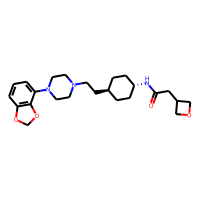
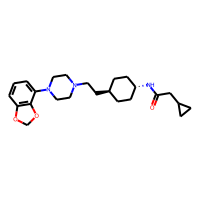
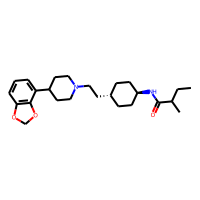
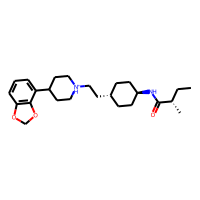
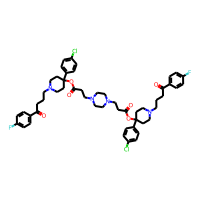
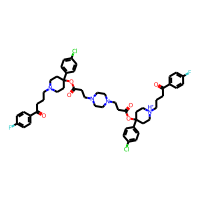
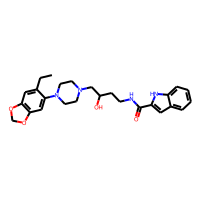
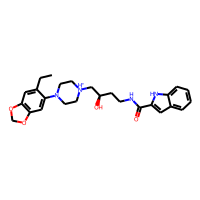
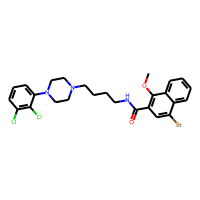
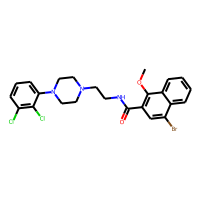
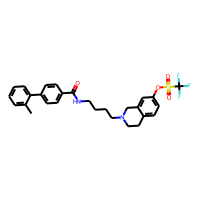
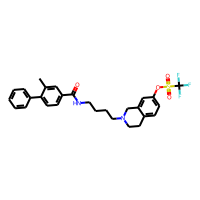
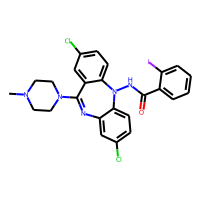
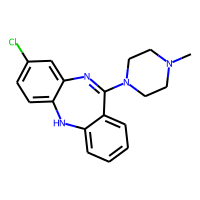
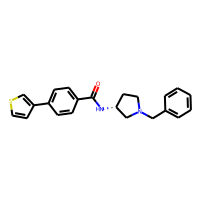
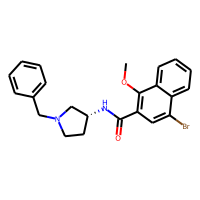
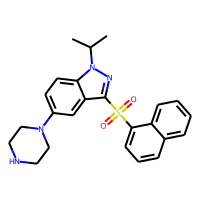
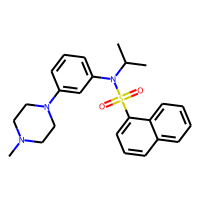
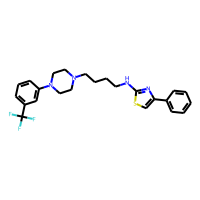
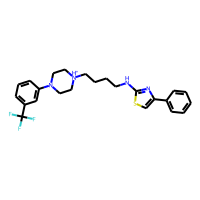

In [7]:
dataset = ds.dataset('/data/outchunks', format="feather")
combined_df = dataset.to_table().to_pandas()

PandasTools.AddMoleculeColumnToFrame(combined_df, smilesCol='standard_smiles', molCol='self')
PandasTools.AddMoleculeColumnToFrame(combined_df, smilesCol='nearest_neighbor_smiles', molCol='near_neighbor')
PandasTools.RenderImagesInAllDataFrames()
combined_df = combined_df.reset_index(drop=True)
cols_to_keep = ['canonical_id', 'ki', 'nearest_neighbor_name', 'nearest_neighbor_distance', 'self', 'near_neighbor']
combined_df = combined_df[cols_to_keep]
combined_df

NameError: name 'de' is not defined